In [20]:

#import lightgbm
import random
import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit, KFold, TimeSeriesSplit
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings(action='ignore')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

 #점수 측정을 위한 코드
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))


#건물번호 지정
bnum = 54


In [7]:
# merged_train_df = pd.read_csv('./data/train_preprocessed_wsw.csv')
# test = merged_train_df.loc[(merged_train_df['building_number'] == 22) &(merged_train_df['week'] == 22) & (merged_train_df['day']==2)]
# test['max'] = np.max(test['power_consumption'])
# test['max'] = np.min(test['power_consumption'])

In [42]:
def data(df):
    df = pd.read_csv('./data/train_preprocessed_wsw.csv')
    df['cooling_to_total_area_ratio'] = df['cool_to_total_area_ratio'] = df['cooling_area'] / df['total_area']
    
    grouped = merged_train_df.groupby(['building_number', 'week', 'day','holiday'])

    # 각 그룹의 최대값과 최소값 계산
    df['max_power'] = grouped['power_consumption'].transform(np.max)
    df['min_power'] = grouped['power_consumption'].transform(np.min)

    # 각 그룹의 최대값과 최소값의 평균 계산
    grouped = df.groupby(['building_number', 'week', 'day','holiday'])
    df['avg_max_power'] = grouped['max_power'].transform(np.mean)
    df['avg_min_power'] = grouped['min_power'].transform(np.mean)

        
    df['solar_to_ess_ratio'] = df['solar_power_capacity'] / df['ess_capacity']
    df['efficiency'] = df['pcs_capacity'] / df['power_consumption']
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0,inplace=True)
    ## StandardScaler 객체 생성
    #from sklearn.preprocessing import MinMaxScaler
    # scaler = MinMaxScaler()
    ## 데이터 표준화
    # df['solar_to_ess_ratio'] = scaler.fit_transform(df[['solar_to_ess_ratio']])
    # df['efficiency'] = scaler.fit_transform(df[['efficiency']])
    df.drop(columns=['Unnamed: 0','sunshine','pcs_capacity','ess_capacity','solar_power_capacity','solar_radiation','total_area','cooling_area'],inplace= True)
        
    return df

best iterations: 465
SMAPE : 23.54147603767055


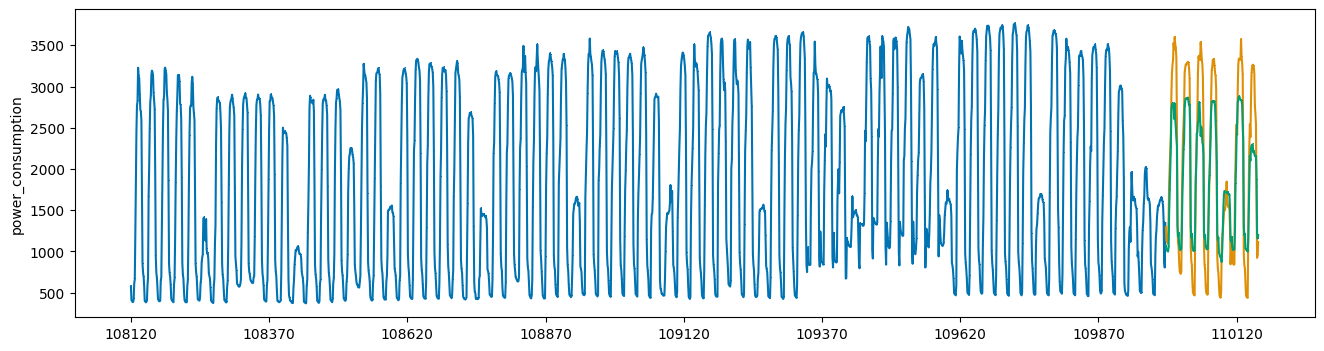

In [18]:
#불러오기
merged_train_df = pd.read_csv('./data/train_preprocessed_wsw.csv')
merged_train_df.drop(columns=['Unnamed: 0'],inplace= True)
merged_train_df.head()
xgb_params = pd.read_csv('./parameters/hyperparameter_xgb_wsw.csv')
xgb_params.drop(columns=['Unnamed: 0'],inplace= True)

y = merged_train_df.loc[merged_train_df.building_number == bnum, 'power_consumption']
x = merged_train_df.loc[merged_train_df.building_number == bnum, ].drop(columns=['power_consumption'])

y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168) # 24시간*7일 = 168

## 주황색이 실제 전력소비량, 초록색이 예측값입니다.
## mse가중치 사용 O
xgb_reg = XGBRegressor(seed = 0, tree_method="hist",  gpu_id=0, n_estimators = xgb_params.iloc[bnum-1,7], eta = xgb_params.iloc[bnum-1, 1],
                           min_child_weight = xgb_params.iloc[bnum, 2], max_depth = xgb_params.iloc[bnum-1, 3],
                           colsample_bytree=xgb_params.iloc[bnum, 4], subsample=xgb_params.iloc[bnum-1, 5])
xgb_reg.set_params(**{'objective':weighted_mse(100)})
xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],
        early_stopping_rounds=300,
       verbose=False)

pred = xgb_reg.predict(x_valid)
pred = pd.Series(pred)
pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('best iterations: {}'.format(xgb_reg.best_iteration))
print('SMAPE : {}'.format(SMAPE(y_valid, pred)))

Feature 0: 0.0
Feature 1: 0.038637809455394745
Feature 2: 0.0002367171982768923
Feature 3: 0.0018898501293733716
Feature 4: 0.0008302989881485701
Feature 5: 0.0006639552884735167


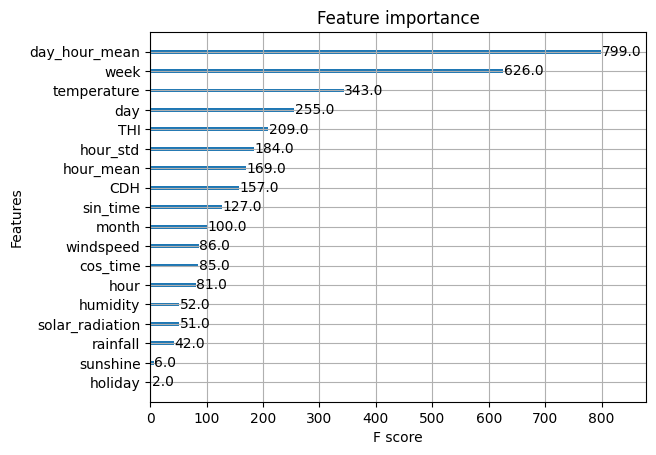

In [10]:
import xgboost as xgb
import matplotlib.pyplot as plt

# 피처 중요도 확인
feature_importances = xgb_reg.feature_importances_

# # 피처 중요도를 출력합니다.(위에서 5개만)
# for i, feat_importance in enumerate(feature_importances):
#   print(f"Feature {i}: {feat_importance}")

# 피처 중요도를 시각화합니다.
xgb.plot_importance(xgb_reg)
plt.show()

iterations: 가중치 편향 업데이트 횟수, 이값으로 과적합을 방지 할 수 있음

best iterations: 482
SMAPE : 32.4169515345858


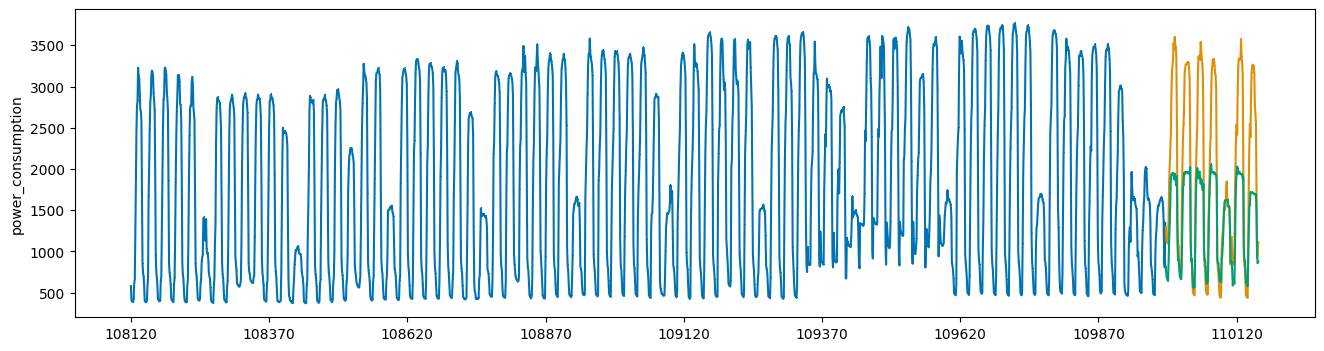

In [21]:
#불러오기
merged_train_df = pd.read_csv('./data/train_preprocessed_wsw.csv')
merged_train_df.drop(columns=['Unnamed: 0'],inplace= True)
merged_train_df.head()
xgb_params = pd.read_csv('./parameters/hyperparameter_xgb_wsw.csv')
xgb_params.drop(columns=['Unnamed: 0'],inplace= True)
#추가 전처리
merged_train_df['power_consumption'] = np.log1p(merged_train_df['power_consumption'])

y = merged_train_df.loc[merged_train_df.building_number == bnum, 'power_consumption']
x = merged_train_df.loc[merged_train_df.building_number == bnum, ].drop(columns=['power_consumption'])
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168) # 24시간*7일 = 168

## mse가중치 사용 O
xgb_reg = XGBRegressor(seed = 0, tree_method="hist",  gpu_id=0, n_estimators = xgb_params.iloc[bnum-1,7], eta = xgb_params.iloc[bnum-1, 1],
                           min_child_weight = xgb_params.iloc[bnum, 2], max_depth = xgb_params.iloc[bnum-1, 3],
                           colsample_bytree=xgb_params.iloc[bnum, 4], subsample=xgb_params.iloc[bnum-1, 5])
xgb_reg.set_params(**{'objective':weighted_mse(100)})

xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],
        early_stopping_rounds=300,
       verbose=False)

y_train =np.expm1(y_train)
y_valid =np.expm1(y_valid)

pred = xgb_reg.predict(x_valid)
pred = np.expm1(pred)
pred = pd.Series(pred)
pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('best iterations: {}'.format(xgb_reg.best_iteration))
print('SMAPE : {}'.format(SMAPE(y_valid, pred)))

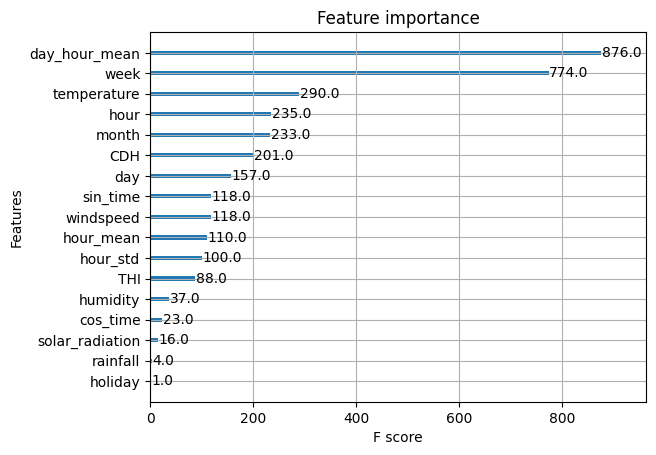

In [37]:
import xgboost as xgb
import matplotlib.pyplot as plt

# 피처 중요도 확인
feature_importances = xgb_reg.feature_importances_

# # 피처 중요도를 출력합니다.(위에서 5개만)
# for i, feat_importance in enumerate(feature_importances):
#   print(f"Feature {i}: {feat_importance}")

# 피처 중요도를 시각화합니다.
xgb.plot_importance(xgb_reg)
plt.show()